In [ ]:
import matplotlib.pylab as plt
import numpy as np
import scipy.integrate
import scipy.io
from mpl_toolkits.mplot3d import Axes3D
import os

data = scipy.io.loadmat('./data/reaction_diffusion_big.mat')
u = data['u']
x = data['y']
y = data['x']

In [ ]:
# for i in range(u.shape[2]):
for i in range(10):
    plt.pcolor(u[:,:, i])
    plt.show()

In [34]:
# Reshape each frame/timepoint into a vector and store as columns in a matrix; Perform SVD on this.
for i in range(u.shape[2]):
    next_frame = np.reshape(u[:,:, i], (u.shape[0] * u.shape[1], 1))
    if i == 0: 
        flattened_images = next_frame
    else: 
        flattened_images = np.hstack((flattened_images, next_frame))
        

In [36]:
# Since our data is stored as columns of the matrix X, the columns of U will store the Principal Components and
# the columns of Sigma V* give us the coordinates in this PC space.

[U,S,V] = np.linalg.svd(flattened_images, full_matrices=False)
Sigma = np.diag(S)

In [54]:
print(V.shape)

(201, 201)


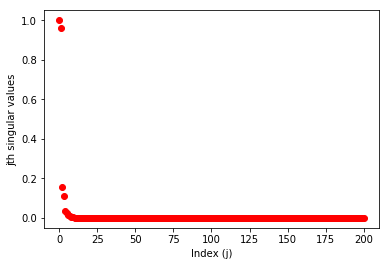

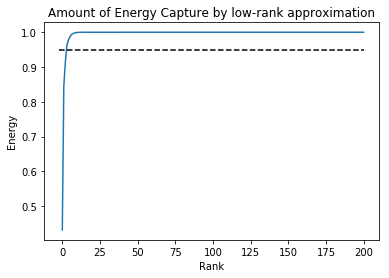

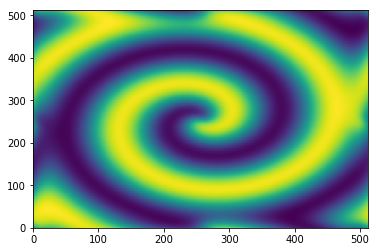

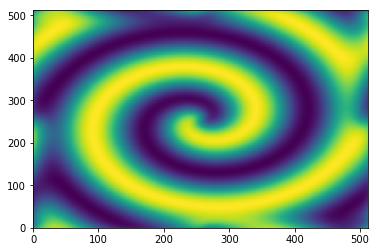

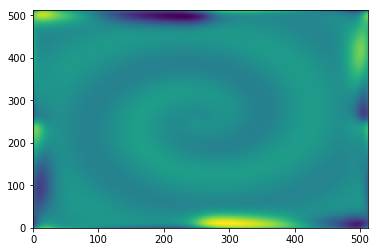

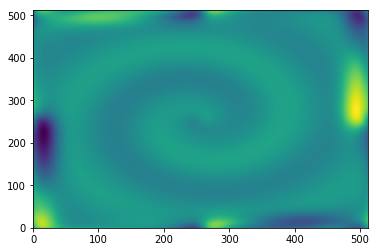

In [42]:
# Plot the normalized singular values

plt.figure()
singular_values = S / np.max(S)
plt.plot(singular_values, 'ro')
plt.xlabel('Index (j)')
plt.ylabel('jth singular values')

# Plot energy versus rank
energy = np.cumsum(singular_values) / np.sum(singular_values)
plt.figure()
plt.plot(energy)
plt.plot([-2, 200], [0.95, 0.95], 'k--')
plt.xlabel('Rank')
plt.ylabel('Energy')
plt.title('Amount of Energy Capture by low-rank approximation')

# Plot the first few principal components
rank = 4
for i in range(rank):
    plt.figure()
    pc = U[:, i].reshape((u.shape[0], u.shape[1]))
    plt.pcolor(pc)
    
U_r = U[:, :rank]
S_r = np.diag(S)[:rank, :rank]
V_r = V[:rank, :]

# inputs is the low rank coordinates (in PC space) at time t, outputs at time (t+1)
inputs = V_r.T[:-2, :]
outputs = V_r.T[1:-1, :]
test_in = V_r.T[-2, :]
test_out = V_r.T[-1, :]
    

In [43]:
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers

l1 = 0  # L1 regularization of network weights\
l2 = 0 # L2 Regularization of network weights

# can define a custom activation function and pass it as a parameter with 'activation' as well. 
model = Sequential()
model.add(Dense(1000, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2), input_shape = (rank,)))
model.add(Dense(1000, kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2), activation='relu'))
model.add(Dense(1000, kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2), activation='relu'))
model.add(Dense(1000, kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2), activation='relu'))
model.add(Dense(1000, kernel_regularizer=regularizers.l1_l2(l1=l1, l2=l2), activation='relu'))
model.add(Dense(1000, activation='linear'))

model.add(Dense(rank, activation='linear'))

model.compile(optimizer='adadelta', loss='mean_squared_error')

In [44]:
model.fit(inputs, outputs, 
         epochs=100,
         batch_size=100,
         shuffle=True, 
         validation_split = 0.2) # use 20 % of data as a validation dataset

Train on 159 samples, validate on 40 samples
Epoch 1/100
159/159 [==============================] - 1s 3ms/step - loss: 0.0045 - val_loss: 0.0069
Epoch 2/100
159/159 [==============================] - 0s 816us/step - loss: 0.0039 - val_loss: 0.0075
Epoch 3/100
159/159 [==============================] - 0s 772us/step - loss: 0.0038 - val_loss: 0.0070
Epoch 4/100
159/159 [==============================] - 0s 779us/step - loss: 0.0036 - val_loss: 0.0068
Epoch 5/100
159/159 [==============================] - 0s 822us/step - loss: 0.0035 - val_loss: 0.0071
Epoch 6/100
159/159 [==============================] - 0s 780us/step - loss: 0.0034 - val_loss: 0.0072
Epoch 7/100
159/159 [==============================] - 0s 766us/step - loss: 0.0030 - val_loss: 0.0079
Epoch 8/100
159/159 [==============================] - 0s 820us/step - loss: 0.0030 - val_loss: 0.0076
Epoch 9/100
159/159 [==============================] - 0s 796us/step - loss: 0.0027 - val_loss: 0.0081
Epoch 10/100
159/159 [========

Epoch 79/100
159/159 [==============================] - 0s 762us/step - loss: 2.9283e-04 - val_loss: 0.0041
Epoch 80/100
159/159 [==============================] - 0s 769us/step - loss: 2.1682e-04 - val_loss: 0.0041
Epoch 81/100
159/159 [==============================] - 0s 751us/step - loss: 2.1493e-04 - val_loss: 0.0043
Epoch 82/100
159/159 [==============================] - 0s 762us/step - loss: 2.9569e-04 - val_loss: 0.0045
Epoch 83/100
159/159 [==============================] - 0s 755us/step - loss: 3.9300e-04 - val_loss: 0.0047
Epoch 84/100
159/159 [==============================] - 0s 769us/step - loss: 6.1928e-04 - val_loss: 0.0047
Epoch 85/100
159/159 [==============================] - 0s 760us/step - loss: 0.0010 - val_loss: 0.0049
Epoch 86/100
159/159 [==============================] - 0s 788us/step - loss: 0.0010 - val_loss: 0.0047
Epoch 87/100
159/159 [==============================] - 0s 753us/step - loss: 6.3206e-04 - val_loss: 0.0050
Epoch 88/100
159/159 [==============

### Check NN performance

Expected PC coordinates:
 [[-0.02785978  0.09811019  0.02306794 -0.12282263]] 

 calculated: 
 [[ 0.02477968]
 [ 0.00116619]
 [ 0.08208765]
 [-0.05376217]]


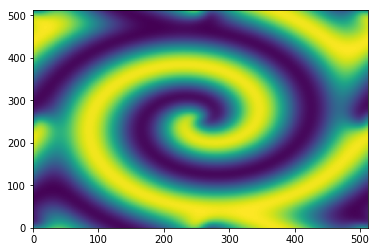

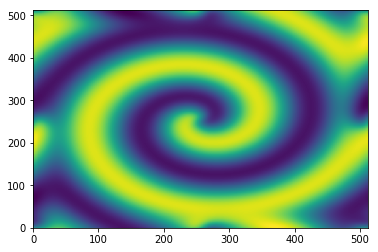

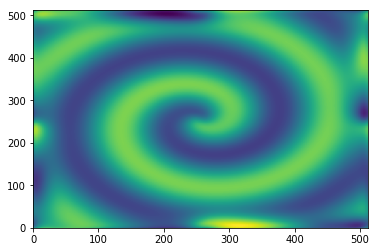

In [56]:
y_NN = model.predict(np.expand_dims(test_in, axis=0))

print("Expected PC coordinates:\n", np.expand_dims(test_out, axis=0), "\n\n calculated: \n", y_NN.T)

Sigma = np.diag(S)
actual = np.dot(np.matmul(U, Sigma), V[:, -1]).reshape((u.shape[0], u.shape[1]))
low_rank = np.dot(np.matmul(U_r, S_r), V_r[:, -1]).reshape((u.shape[0], u.shape[1]))
NN = np.dot(np.matmul(U_r, S_r), y_NN.T).reshape((u.shape[0], u.shape[1]))

plt.figure()
plt.pcolor(actual)

plt.figure()
plt.pcolor(low_rank)

plt.figure()
plt.pcolor(NN)


